Imports

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.utils import from_networkx
from torch_geometric.nn import GCNConv
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, roc_curve, precision_recall_curve
)
from sklearn.model_selection import train_test_split


Load & Inspect Data

In [16]:
df = pd.read_csv("GNN-fraud-detection/data/train_transaction.csv")

print("Dataset Shape:", df.shape)
display(df[['TransactionID', 'card1', 'TransactionAmt', 'isFraud']].head())
print("\nClass Distribution:")
print(df['isFraud'].value_counts())


Dataset Shape: (590540, 394)


,TransactionID,card1,TransactionAmt,isFraud
0,2987000,13926,68.5,0
1,2987001,2755,29.0,0
2,2987002,4663,59.0,0
3,2987003,18132,50.0,0
4,2987004,4497,50.0,0



Class Distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64


Build Graph Function

In [18]:
def build_transaction_graph(df, sample_size=50000):
    df = df[['TransactionID','card1','TransactionAmt','isFraud']].dropna()
    df = df.sample(sample_size, random_state=42)

    G = nx.Graph()

    for _, r in df.iterrows():
        user = f"user_{int(r.card1)}"
        txn  = f"txn_{int(r.TransactionID)}"

        G.add_node(user, node_type=0, amount=0.0, label=-1)
        G.add_node(txn,  node_type=1,
                   amount=float(r.TransactionAmt),
                   label=int(r.isFraud))
        G.add_edge(user, txn)

    data = from_networkx(G)
    data.x = data.amount.view(-1,1).float()
    data.y = data.label.long()
    return data


Build Graph

In [21]:
data = build_transaction_graph(df)

print(type(data))
print(data)

print("Number of nodes:", data.num_nodes)
print("Number of edges:", data.num_edges)
print("Node feature shape:", data.x.shape)
print("Labels shape:", data.y.shape)



<class 'torch_geometric.data.data.Data'>
Data(edge_index=[2, 100000], node_type=[55657], amount=[55657], label=[55657], num_nodes=55657, x=[55657, 1], y=[55657])
Number of nodes: 55657
Number of edges: 100000
Node feature shape: torch.Size([55657, 1])
Labels shape: torch.Size([55657])


Train / Validation Split

In [23]:
labels = data.y.cpu().numpy()
txn_idx = np.where(labels >= 0)[0]

train_idx, val_idx = train_test_split(
    txn_idx,
    test_size=0.2,
    random_state=42,
    stratify=labels[txn_idx]
)

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask   = torch.zeros(data.num_nodes, dtype=torch.bool)

data.train_mask[train_idx] = True
data.val_mask[val_idx] = True


Model Definition

In [26]:
class FraudGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1,16)
        self.conv2 = GCNConv(16,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = data.to(device)

model = FraudGCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = torch.nn.CrossEntropyLoss(weight=torch.tensor([1.0,20.0]).to(device))

train_losses, val_losses = [], []

for epoch in range(20):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch {epoch+1:02d} | Train {loss:.3f} | Val {val_loss:.3f}")


Epoch 01 | Train 9.463 | Val 9.385
Epoch 02 | Train 2.629 | Val 2.607
Epoch 03 | Train 3.421 | Val 3.275
Epoch 04 | Train 5.362 | Val 5.131
Epoch 05 | Train 5.408 | Val 5.175
Epoch 06 | Train 4.260 | Val 4.078
Epoch 07 | Train 2.340 | Val 2.242
Epoch 08 | Train 0.786 | Val 0.786
Epoch 09 | Train 2.492 | Val 2.471
Epoch 10 | Train 2.880 | Val 2.856
Epoch 11 | Train 2.043 | Val 2.027
Epoch 12 | Train 0.706 | Val 0.706
Epoch 13 | Train 1.550 | Val 1.490
Epoch 14 | Train 2.189 | Val 2.097
Epoch 15 | Train 2.157 | Val 2.067
Epoch 16 | Train 1.557 | Val 1.496
Epoch 17 | Train 0.732 | Val 0.722
Epoch 18 | Train 1.455 | Val 1.446
Epoch 19 | Train 1.948 | Val 1.932
Epoch 20 | Train 1.558 | Val 1.547


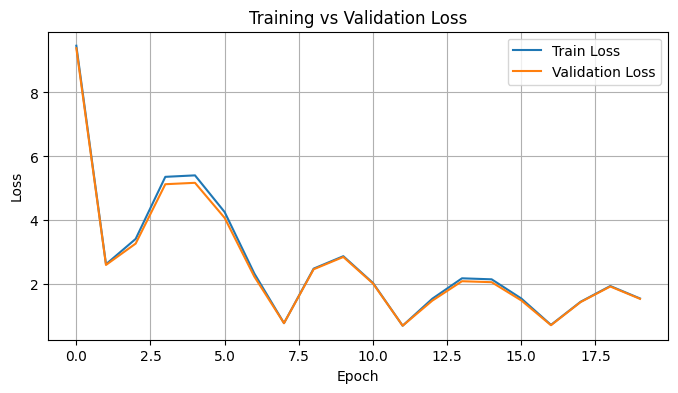

In [32]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.grid(True)
plt.show()


In [35]:
model.eval()
with torch.no_grad():
    logits = model(data)
    probs = torch.softmax(logits[data.val_mask], dim=1)[:,1].cpu().numpy()
    labels = data.y[data.val_mask].cpu().numpy()

preds = (probs > 0.9).astype(int)

print("Accuracy :", accuracy_score(labels,preds))
print("Precision:", precision_score(labels,preds, zero_division=0))
print("Recall   :", recall_score(labels,preds, zero_division=0))
print("AUC      :", roc_auc_score(labels,probs))


Accuracy : 0.9616
Precision: 0.0
Recall   : 0.0
AUC      : 0.46045830842568547


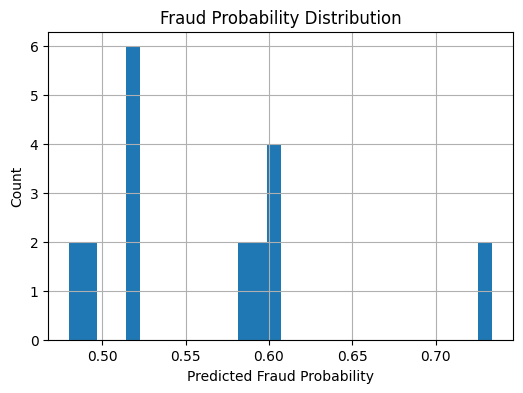

In [44]:

plt.figure(figsize=(6,4))
plt.hist(probs, bins=30)
plt.xlabel("Predicted Fraud Probability")
plt.ylabel("Count")
plt.title("Fraud Probability Distribution")
plt.grid(True)
plt.show()


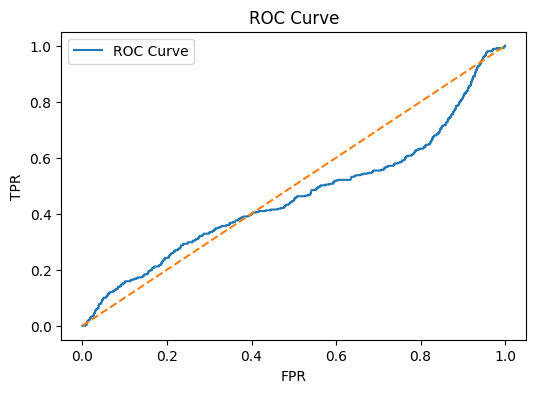

In [37]:
fpr, tpr, _ = roc_curve(labels, probs)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="ROC Curve")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()
plt.show()


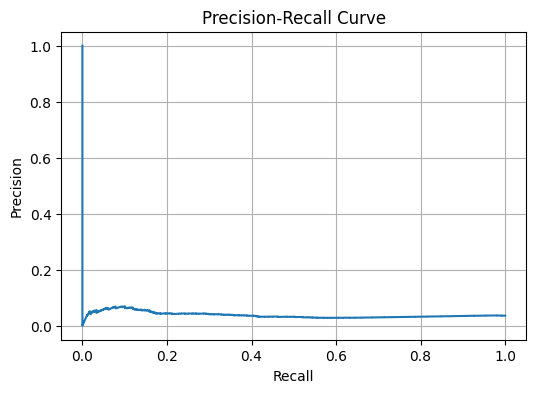

In [39]:
p, r, _ = precision_recall_curve(labels, probs)

plt.figure(figsize=(6,4))
plt.plot(r, p)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


In [41]:
sample_df = df.sample(10, random_state=42).copy()
sample_data = build_transaction_graph(sample_df, 10).to(device)

with torch.no_grad():
    logits = model(sample_data)
    probs = torch.softmax(logits, dim=1)[:,1].cpu().numpy()

txn_mask = sample_data.y.cpu().numpy() >= 0
sample_df["Predicted_isFraud"] = (probs[txn_mask] > 0.9).astype(int)

sample_df[['TransactionID','TransactionAmt','isFraud','Predicted_isFraud']]


,TransactionID,TransactionAmt,isFraud,Predicted_isFraud
470624,3457624,724.000,0,0
565820,3552820,108.500,0,0
284083,3271083,47.950,0,0
239689,3226689,100.599,0,0
281855,3268855,107.950,0,0
413908,3400908,280.000,0,0
413692,3400692,311.950,0,0
474182,3461182,330.990,0,0
370788,3357788,10.392,1,0
28757,3015757,335.000,0,0
